In [1]:
%reset -sf

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from flow import *
from utils import *
import get_data as gd
import gc

import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices())
print()

2023-11-21 12:04:08.731997: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]



In [35]:
import mplhep as hep

hep.style.use("ATLAS")

### Load data

In [36]:
processor = gd.DataProcessor()
path = "/root/work/truth/signal/*npz"
processor.load_files(path)

(
    CGLMP,
    Higgs,
    LeadLep,
    LepM,
    LepP,
    NuM,
    NuP,
    MET,
    Wm,
    Wp,
    diLep,
    SubLep,
    Xi,
) = processor.files
GEV = 1e3

['/root/work/truth/signal/CGLMP.npz', '/root/work/truth/signal/Higgs.npz', '/root/work/truth/signal/LeadLepton.npz', '/root/work/truth/signal/LeptonM.npz', '/root/work/truth/signal/LeptonP.npz', '/root/work/truth/signal/LmNu.npz', '/root/work/truth/signal/LpNu.npz', '/root/work/truth/signal/MET.npz', '/root/work/truth/signal/WmBoson.npz', '/root/work/truth/signal/WpBoson.npz', '/root/work/truth/signal/diLepton.npz', '/root/work/truth/signal/subLeadLepton.npz', '/root/work/truth/signal/xi_xyz.npz']



In [3]:
cut_pre_pt_lead = LeadLep["pt"] > 22 * GEV
cut_pre_pt_sub = SubLep["pt"] > 15 * GEV
cut_pre_dilep_m = diLep["m"] > 10 * GEV
cut_pre_pt_miss = MET["pt"] > 20 * GEV
cut_pre = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss

del cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss

In [75]:
def hist(
    data=None,
    label=None,
    title=r"Normalized $p^{miss}_{x}$ of MET",
    range=None,
    unit="GeV",
):
    if data is None:
        data = [MET["px"], MET[cut_pre]["px"]]
    if label is None:
        label = [r"$MET_{x}$", r"$MET^{cut}_{x}$"]
    if range is None:
        min_val = np.min(data[0])
        max_val = np.max(data[0])
        range_val = [min_val, max_val]
    else:
        range_val = range

    n_bins = 150
    fig, axs = plt.subplots(
        2,
        1,
        figsize=(9, 6),
        dpi=100,
        sharex=True,
        gridspec_kw={"height_ratios": [3, 1], "hspace": 0.1},
    )  # adjust hspace
    arr0 = axs[0].hist(
        data[0],
        bins=n_bins,
        histtype="step",
        density=True,
        color="red",
        linewidth=2,
        label=label[0],
        range=range_val,
    )
    arr1 = axs[0].hist(
        data[1],
        bins=n_bins,
        histtype="step",
        density=True,
        color="blue",
        linewidth=2,
        label=label[1],
        range=range_val,
    )
    axs[0].legend()
    axs[0].set_title(title)
    axs[0].tick_params(
        axis="x", which="both", bottom=False, top=False, labelbottom=False
    )  # remove x-ticks
    axs[0].set_ylabel("(Normalized) counts")

    ratio = np.divide(arr1[0], arr0[0], where=(arr0[0] != 0))
    axs[1].set_xlabel(label[0] + f" [{unit}]")
    axs[1].plot(arr0[1][:-1], ratio, "--", color="black", linewidth=1)
    axs[1].axhline(
        y=1, color="grey", linestyle="--", alpha=0.5
    )  # add horizontal line at y=1
    axs[1].set_ylabel("ratio")
    axs[1].tick_params(axis="x", which="both", pad=10)  # adjust pad
    plt.show()
    plt.close()

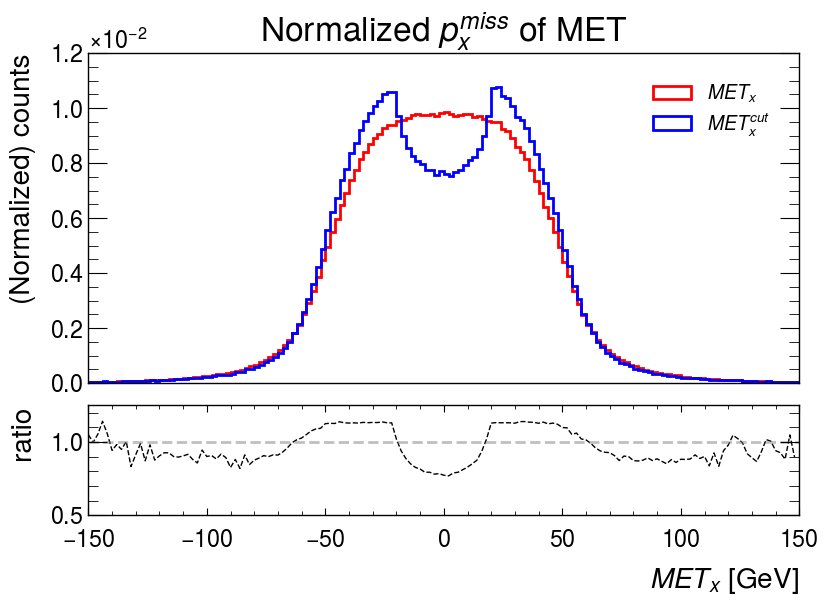

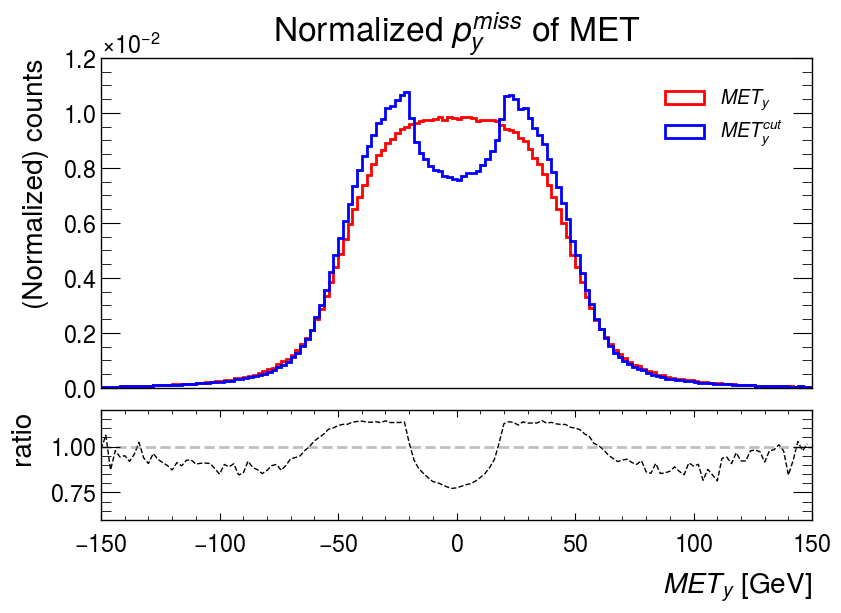

In [76]:
hist(
    [MET["px"]/GEV, MET[cut_pre]["px"]/GEV],
    [r"$MET_{x}$", r"$MET^{cut}_{x}$"],
    r"Normalized $p^{miss}_{x}$ of MET",
    [-150, 150],
)
hist(
    [MET["py"]/GEV, MET[cut_pre]["py"]/GEV],
    [r"$MET_{y}$", r"$MET^{cut}_{y}$"],
    r"Normalized $p^{miss}_{y}$ of MET",
    [-150, 150],
)

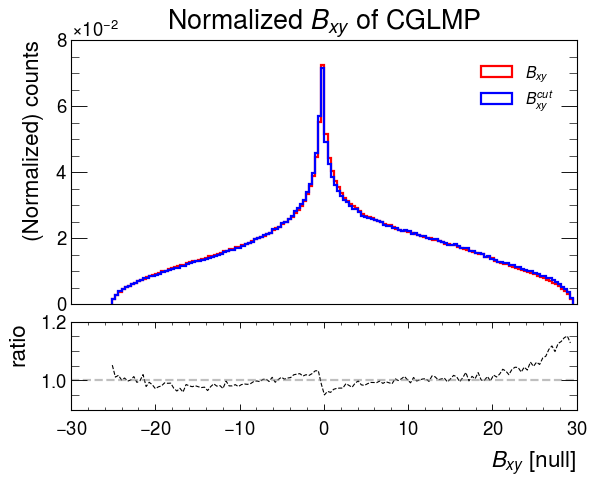

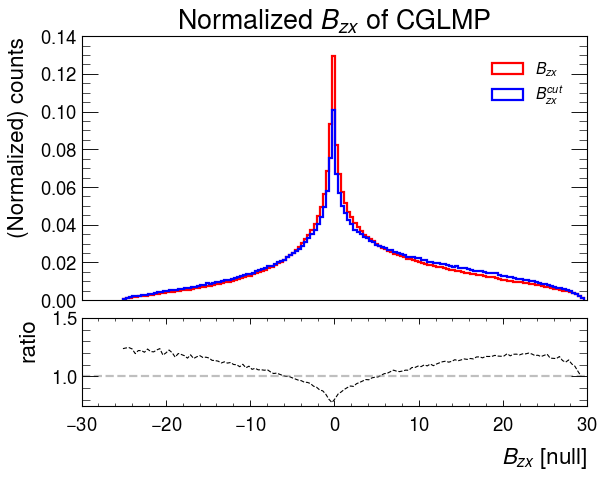

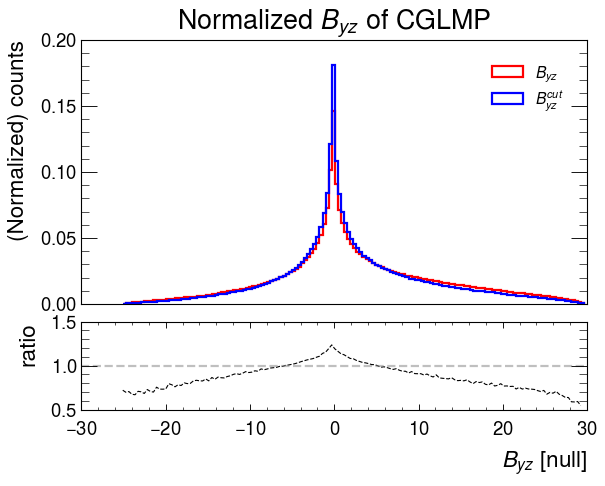

In [74]:
hist(
    [CGLMP["Bxy"], CGLMP[cut_pre]["Bxy"]],
    [r"$B_{xy}$", r"$B_{xy}^{cut}$"],
    r"Normalized $B_{xy}$ of CGLMP",
    unit="null",
)
hist(
    [CGLMP["Bzx"], CGLMP[cut_pre]["Bzx"]],
    [r"$B_{zx}$", r"$B_{zx}^{cut}$"],
    r"Normalized $B_{zx}$ of CGLMP",
    unit="null",
)
hist(
    [CGLMP["Byz"], CGLMP[cut_pre]["Byz"]],
    [r"$B_{yz}$", r"$B_{yz}^{cut}$"],
    r"Normalized $B_{yz}$ of CGLMP",
    unit="null",
)

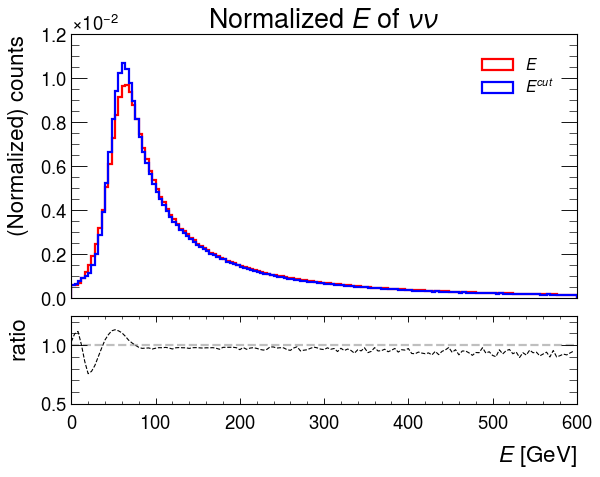

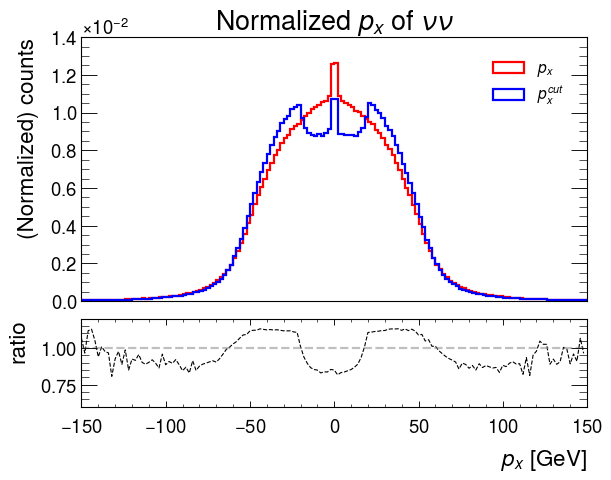

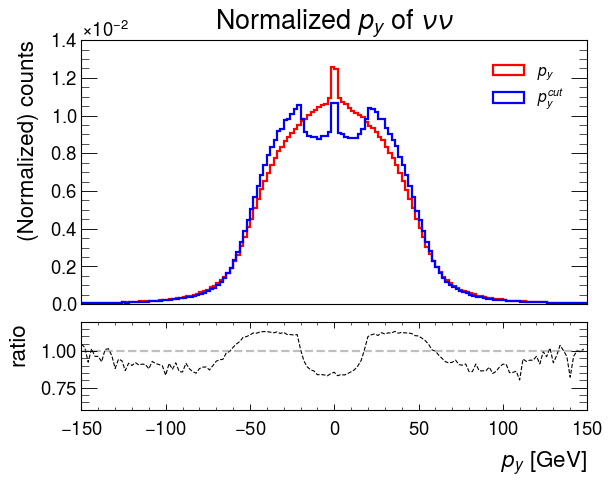

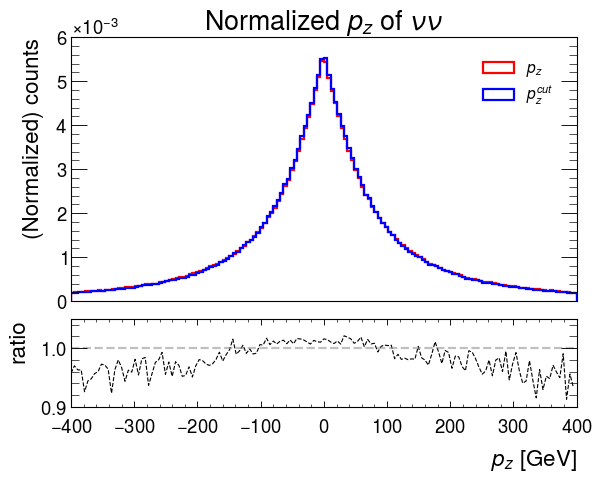

In [73]:
dinu = NuP + NuM
hist(
    [dinu["E"]/GEV, dinu[cut_pre]["E"]/GEV],
    [r"$E$", r"$E^{cut}$"],
    r"Normalized $E$ of $\nu\nu$",
    [0, 0.6e3],
)
hist(
    [dinu["px"]/GEV, dinu[cut_pre]["px"]/GEV],
    [r"$p_{x}$", r"$p^{cut}_{x}$"],
    r"Normalized $p_{x}$ of $\nu\nu$",
    [-150, 150],
)
hist(
    [dinu["py"]/GEV, dinu[cut_pre]["py"]/GEV],
    [r"$p_{y}$", r"$p^{cut}_{y}$"],
    r"Normalized $p_{y}$ of $\nu\nu$",
    [-150, 150],
)
hist(
    [dinu["pz"]/GEV, dinu[cut_pre]["pz"]/GEV],
    [r"$p_{z}$", r"$p^{cut}_{z}$"],
    r"Normalized $p_{z}$ of $\nu\nu$",
    [-400, 400],
)

In [34]:
# observed (Y)
## leps
lep_kin = (
    pd.concat([LepP[cut_pre].iloc[:, 0:4], LepM[cut_pre].iloc[:, 0:4]], axis=1) / GEV
)
lep_kin_exp = pd.concat(
    [
        LepP[cut_pre].iloc[:, 4:6] / GEV,
        LepP[cut_pre].iloc[:, 6:-1],
        LepM[cut_pre].iloc[:, 4:6] / GEV,
        LepM[cut_pre].iloc[:, 6:-1],
    ],  # discard the last column (y) owing to inf problems when stdscalar
    axis=1,
)
## MET
MET_kin = MET[cut_pre].iloc[:, 1:3] / GEV
CGLMP = CGLMP[cut_pre]
# y -> observed params
MET_kin = pd.concat([MET_kin, CGLMP], axis=1)
print("MET_kin shape:", MET_kin.shape)
print(MET_kin.head(3))
print()

# interest (X)
# x -> interested unknowns
## neus
nu_kin = dinu[cut_pre].iloc[:, 0:4] / GEV
nu_kin_exp = pd.concat(
    [
        NuP[cut_pre].iloc[:, 4:6] / GEV,
        NuP[cut_pre].iloc[:, 6:-1],
        NuM[cut_pre].iloc[:, 4:6] / GEV,
        NuM[cut_pre].iloc[:, 6:-1],
    ],  # discard the last column (y) owing to inf problems when stdscalar
    axis=1,
)
dinu_kin = pd.concat(
    [
        nu_kin,
    ],
    axis=1,
)
print("dinu_kin shape:", dinu_kin.shape)
print(dinu_kin.head(3))
print()

del processor  # Clear the instance
del (
    CGLMP,
    Higgs,
    LeadLep,
    LepM,
    LepP,
    NuM,
    NuP,
    MET,
    Wm,
    Wp,
    diLep,
    SubLep,
    Xi,
)  # Clear the dataframes
del (lep_kin, nu_kin, nu_kin_exp)
gc.collect()

MET_kin shape: (1378510, 5)
           px         py       Bxy       Byz       Bzx
7   96.335650  47.095450  -5.57360  9.804710  -3.01418
9  -26.992604 -70.883859  18.68250  5.810810  16.36950
10  44.222846 -15.383637   6.54512  0.334199   3.69670

dinu_kin shape: (1378510, 4)
             E         px         py          pz
7   153.433431  96.335650  47.095450 -105.565620
9   187.088398 -26.992604 -70.883859 -170.813820
10  105.357433  44.222846 -15.383637   92.722389



78729

### Preprocessing

In [210]:
from sklearn.model_selection import train_test_split

# sampling
np.random.seed(42)  # set random seed
indices_arr = np.arange(dinu_kin.shape[0], dtype="int")
indices_arr = np.random.choice(indices_arr, int(1e4))

# normalize
from sklearn.preprocessing import StandardScaler

SCALAR_int = StandardScaler()
dinu_kin = SCALAR_int.fit_transform(dinu_kin.iloc[indices_arr])
print(f"mean: {dinu_kin.mean()}; std: {dinu_kin.std()}")

SCALAR_MET = StandardScaler()
MET_kin = SCALAR_MET.fit_transform(MET_kin.iloc[indices_arr])
print(f"mean: {MET_kin.mean()}; std: {MET_kin.std()}")

train_indices, test_indices = train_test_split(
    np.arange(len(indices_arr.flatten())),
    train_size=0.8,
    test_size=0.2,
    random_state=42,
)

train_x = dinu_kin[train_indices]
test_x = dinu_kin[test_indices]
train_y = MET_kin[train_indices]
test_y = MET_kin[test_indices]

print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nTesting data shape: {test_y.shape}."
)
print()

mean: 1.865174681370263e-17; std: 1.0
mean: -8.881784197001253e-18; std: 1.0
X (Interest)
Training data shape: (8000, 4);
Testing data shape: (2000, 4).
Y (Observed)
Training data shape: (8000, 5);
Testing data shape: (2000, 5).



### Setup

In [221]:
# setup

# *hyperparameter
n_couple_layer = 5
n_hid_layer = 3
n_hid_dim = 512
learning_rate = 1e-5

# * hyperparameter
n_batch = 256
n_epoch = 128
n_display = n_batch

# * hyperparameter
w1 = 0.5  # related to pred loss
w2 = 15.0  # related to latent loss
w3 = 25.0  # related to rev loss
loss_factor = 1.0  # related to rev loss

# interest (momentum)
x_dim = train_x.shape[1]
# observed (MET)
y_dim = train_y.shape[1]

# * hyperparameter
# z_dim = x_dim - y_dim # we only take intrinsic dimension into account
z_dim = 3

tot_dim = y_dim + z_dim
pad_dim = tot_dim - x_dim

# Preprocess
## Pad data
X = train_x.reshape((-1, x_dim))
# print("pad_dim", pad_dim)
pad_x = np.zeros((X.shape[0], pad_dim))
print("pad_x", pad_x.shape)
# print("pad_x", pad_x.shape)
x = np.concatenate([X, pad_x], axis=-1).astype("float32")
print("x", x.shape)
z = np.random.multivariate_normal([0.0] * z_dim, np.eye(z_dim), X.shape[0]).astype(
    "float32"
)
y_hat = train_y.reshape(-1, y_dim)
print("y", y_hat.shape)
print("z", z.shape)
y = np.concatenate([z, y_hat], axis=-1).astype("float32")

print(f"Input dataset shape -> X:{x.shape}, Y: {y.shape}")

n_sample = X.shape[0]
print("n_sample", n_sample)
n_data = n_sample * train_y.shape[1]
print("n_data", n_data)
print()

# Make dataset generator
x_data = tf.data.Dataset.from_tensor_slices(x)
y_data = tf.data.Dataset.from_tensor_slices(y)
dataset = (
    tf.data.Dataset.zip((x_data, y_data))
    .shuffle(buffer_size=X.shape[0])
    .batch(n_batch, drop_remainder=True)
    .repeat()
)

pad_x (8000, 4)
x (8000, 8)
y (8000, 5)
z (8000, 3)
Input dataset shape -> X:(8000, 8), Y: (8000, 8)
n_sample 8000
n_data 40000



### Initialize the model

In [222]:
model = NVP(tot_dim, n_couple_layer, n_hid_layer, n_hid_dim, name="NVP")
x = tfk.Input((tot_dim,))
model(x)
model.summary()

Model: "NVP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer0 (TwoNVPCouplingLaye  multiple                  1063960   
 rs)                                                             
                                                                 
 Layer1 (TwoNVPCouplingLaye  multiple                  1063960   
 rs)                                                             
                                                                 
 Layer2 (TwoNVPCouplingLaye  multiple                  1063960   
 rs)                                                             
                                                                 
 Layer3 (TwoNVPCouplingLaye  multiple                  1063960   
 rs)                                                             
                                                                 
 Layer4 (TwoNVPCouplingLaye  multiple                  1063960 

In [223]:
class Trainer(tfk.Model):
    def __init__(
        self,
        model,
        x_dim,
        y_dim,
        z_dim,
        tot_dim,
        n_couple_layer,
        n_hid_layer,
        n_hid_dim,
        shuffle_type="reverse",
    ):
        super(Trainer, self).__init__()
        self.model = model
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.z_dim = z_dim
        self.tot_dim = tot_dim
        self.x_pad_dim = tot_dim - x_dim
        self.y_pad_dim = tot_dim - (y_dim + z_dim)
        self.n_couple_layer = n_couple_layer
        self.n_hid_layer = n_hid_layer
        self.n_hid_dim = n_hid_dim
        self.shuffle_type = shuffle_type

        self.w1 = w1  # related to pred loss
        self.w2 = w2  # related to latent loss
        self.w3 = w3  # related to rev loss
        self.loss_factor = loss_factor  # related to rev loss
        self.loss_fit = MSE
        self.loss_latent = MMD_multiscale
        self.loss_backward = MMD_multiscale

    def train_step(self, data):
        x_data, y_data = data
        x = x_data[:, : self.x_dim]
        y = y_data[:, -self.y_dim :]
        z = y_data[:, : self.z_dim]
        y_short = tf.concat([z, y], axis=-1)

        # Forward loss
        with tf.GradientTape() as tape:
            y_out = self.model(x_data)
            pred_loss = self.w1 * self.loss_fit(
                y_data[:, self.z_dim :], y_out[:, self.z_dim :]
            )  # [zeros, y] <=> [zeros, yhat]
            output_block_grad = tf.concat(
                [y_out[:, : self.z_dim], y_out[:, -self.y_dim :]], axis=-1
            )  # take out [z, y] only (not zeros)
            latent_loss = self.w2 * self.loss_latent(
                y_short, output_block_grad
            )  # [z, y] <=> [zhat, yhat]
            forward_loss = pred_loss + latent_loss
        grads_forward = tape.gradient(forward_loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads_forward, self.model.trainable_weights))

        # Backward loss
        with tf.GradientTape() as tape:
            x_rev = self.model.inverse(y_data)
            # rev_loss = self.w3 * self.loss_factor * self.loss_fit(x_rev, x_data)
            rev_loss = self.w3 * self.loss_factor * self.loss_backward(x_rev, x_data)
        grads_backward = tape.gradient(rev_loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(
            zip(grads_backward, self.model.trainable_weights)
        )

        total_loss = forward_loss + latent_loss + rev_loss
        return {
            "total_loss": total_loss,
            "forward_loss": forward_loss,
            "latent_loss": latent_loss,
            "rev_loss": rev_loss,
        }

    def test_step(self, data):
        x_data, y_data = data
        return NotImplementedError

In [224]:
trainer = Trainer(
    model, x_dim, y_dim, z_dim, tot_dim, n_couple_layer, n_hid_layer, n_hid_dim
)
trainer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

### Training

In [225]:
# Load the TensorBoard notebook extension.
import datetime


LossFactor = UpdateLossFactor(n_epoch)
logger = NBatchLogger(n_display, n_epoch)

# set log file
%rm -r ./logs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# set callback of tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=5, write_graph=True, write_images=False,)

hist = trainer.fit(
    dataset,
    batch_size=n_batch,
    epochs=n_epoch,
    steps_per_epoch=n_data // n_batch,
    callbacks=[logger, LossFactor, tensorboard_callback],
    verbose=2,
)

=== Started at 2023-11-21 05h:56m:23s ===
Epoch 1/128
 2023-11-21 05h:56m:43s | Epoch: 001/128 | total_loss=2.323181 forward_loss=0.966629 latent_loss=0.528339 rev_loss=0.828212
156/156 - 21s - total_loss: 2.3232 - forward_loss: 0.9666 - latent_loss: 0.5283 - rev_loss: 0.8282 - 21s/epoch - 134ms/step
Epoch 2/128
156/156 - 5s - total_loss: 2.1296 - forward_loss: 0.9362 - latent_loss: 0.5278 - rev_loss: 0.6656 - 5s/epoch - 33ms/step
Epoch 3/128
156/156 - 5s - total_loss: 1.9959 - forward_loss: 0.8707 - latent_loss: 0.4953 - rev_loss: 0.6299 - 5s/epoch - 32ms/step
Epoch 4/128
156/156 - 5s - total_loss: 1.9154 - forward_loss: 0.8633 - latent_loss: 0.4757 - rev_loss: 0.5764 - 5s/epoch - 34ms/step
Epoch 5/128
156/156 - 5s - total_loss: 1.8829 - forward_loss: 0.8514 - latent_loss: 0.4729 - rev_loss: 0.5586 - 5s/epoch - 34ms/step
Epoch 6/128
156/156 - 6s - total_loss: 1.9294 - forward_loss: 0.8577 - latent_loss: 0.4804 - rev_loss: 0.5912 - 6s/epoch - 39ms/step
Epoch 7/128
156/156 - 5s - total_

### Results

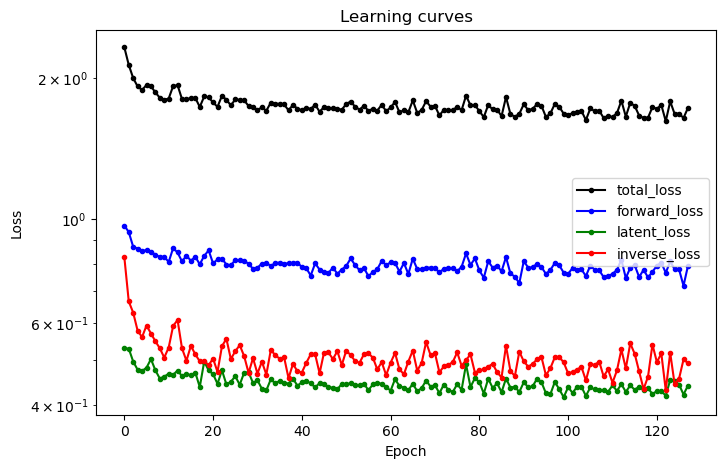

In [226]:
fig, ax = plt.subplots(1, facecolor="white", figsize=(8, 5))
ax.plot(hist.history["total_loss"], "k.-", label="total_loss")
ax.plot(hist.history["forward_loss"], "b.-", label="forward_loss")
ax.plot(hist.history["latent_loss"], "g.-", label="latent_loss")
ax.plot(hist.history["rev_loss"], "r.-", label="inverse_loss")
plt.semilogy()
plt.legend()
plt.title("Learning curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("loss.png")
plt.show()
plt.close()

In [227]:
# # Preprocess
# z = np.random.multivariate_normal([1.0] * z_dim, np.eye(z_dim), test_y.shape[0])
# y = np.concatenate([z, test_y], axis=-1).astype("float32")
# x_pred = model.inverse(y).numpy()
# print("x_pred", x_pred.shape)
# pz_pred = x_pred[:, 3] + x_pred[:, 7]
# pt_pred = np.sqrt(
#     np.square(x_pred[:, 1] + x_pred[:, 5]) + np.square(x_pred[:, 2] + x_pred[:, 6])
# )
# E_pred = x_pred[:, 0] + x_pred[:, 4]

# pz_truth = test_x[:, 3] + test_x[:, 7]
# pt_truth = np.sqrt(
#     np.square(test_x[:, 1] + test_x[:, 5]) + np.square(test_x[:, 2] + test_x[:, 6])
# )
# E_truth = test_x[:, 0] + test_x[:, 4]

In [228]:
# Preprocess
z = np.random.multivariate_normal([1.0] * z_dim, np.eye(z_dim), test_y.shape[0])
y = np.concatenate([z, test_y], axis=-1).astype("float32")
x_pred = model.inverse(y).numpy()
print("x_pred", x_pred.shape)
pz_pred = x_pred[:, 3]
pt_pred = np.sqrt(np.square(x_pred[:, 1]) + np.square(x_pred[:, 2]))
E_pred = x_pred[:, 0]

pz_truth = test_x[:, 3]
pt_truth = np.sqrt(np.square(test_x[:, 1]) + np.square(test_x[:, 2]))
E_truth = test_x[:, 0]

x_pred (2000, 8)


pz -> Pearson coeff: 0.020
E  -> Pearson coeff: 0.009
pt -> Pearson coeff: 0.744


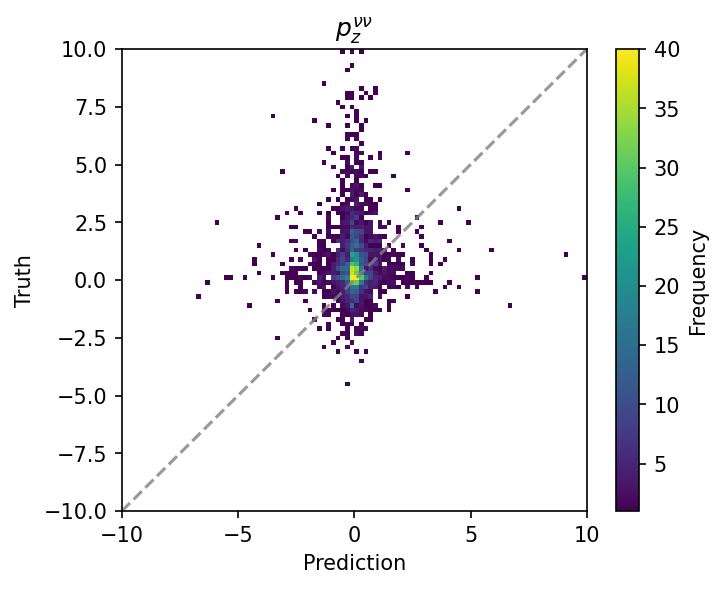

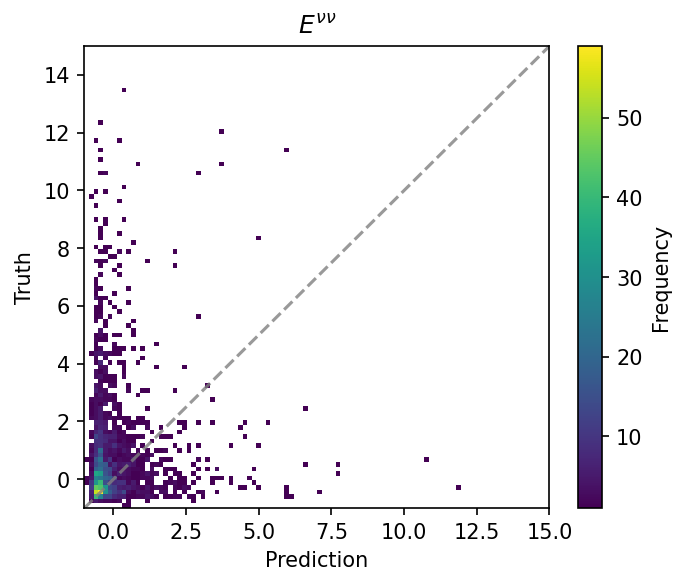

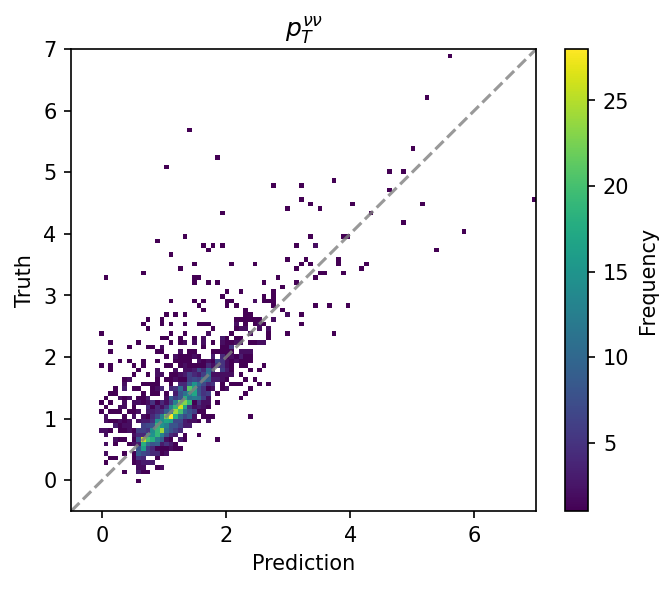

====================== Finished!! ======================


In [229]:
def plot_2d_histogram(pred, truth, title, save_name, bins=100, range=None):
    fig = plt.figure(figsize=(5, 4), dpi=150)
    plt.hist2d(
        pred.flatten(), truth, bins=bins, range=[range, range], cmap="viridis", cmin=1
    )
    cbar = plt.colorbar()
    cbar.set_label("Frequency")
    plt.title(title)
    plt.xlabel("Prediction")
    plt.ylabel("Truth")
    plt.plot(range, range, color="grey", linestyle="--", alpha=0.8)  # add y=x line
    plt.xlim(range)
    plt.ylim(range)
    plt.savefig(save_name)
    plt.show()
    plt.close()


# Plot the results
import scipy as sp

print(f"pz -> Pearson coeff: {sp.stats.pearsonr(pz_truth, pz_pred)[0]:.3f}")
print(f"E  -> Pearson coeff: {sp.stats.pearsonr(E_truth, E_pred)[0]:.3f}")
print(f"pt -> Pearson coeff: {sp.stats.pearsonr(pt_truth, pt_pred)[0]:.3f}")
plot_2d_histogram(
    pz_truth, pz_pred, r"$p^{\nu\nu}_{z}$", save_name="pz.png", range=[-10, 10]
)
plot_2d_histogram(
    E_truth, E_pred, r"$E^{\nu\nu}$", save_name="energy.png", range=[-1, 15]
)
plot_2d_histogram(
    pt_truth, pt_pred, r"$p^{\nu\nu}_{T}$", save_name="pt.png", range=[-0.5, 7]
)

print("====================== Finished!! ======================")

# tensorboard --logdir logs/fit